In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
sns.set_style('whitegrid')

In [3]:
df = pd.read_csv(r'C:\Users\fabio\Documents\DataSets\csv_data\master.csv')

In [4]:
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
country               27820 non-null object
year                  27820 non-null int64
sex                   27820 non-null object
age                   27820 non-null object
suicides_no           27820 non-null int64
population            27820 non-null int64
suicides/100k pop     27820 non-null float64
country-year          27820 non-null object
HDI for year          8364 non-null float64
 gdp_for_year ($)     27820 non-null object
gdp_per_capita ($)    27820 non-null int64
generation            27820 non-null object
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


In [6]:
df.describe()

,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_per_capita ($)
count,27820.000000,27820.000000,2.782000e+04,27820.000000,8364.000000,27820.000000
mean,2001.258375,242.574407,1.844794e+06,12.816097,0.776601,16866.464414
std,8.469055,902.047917,3.911779e+06,18.961511,0.093367,18887.576472
min,1985.000000,0.000000,2.780000e+02,0.000000,0.483000,251.000000
25%,1995.000000,3.000000,9.749850e+04,0.920000,0.713000,3447.000000
50%,2002.000000,25.000000,4.301500e+05,5.990000,0.779000,9372.000000
75%,2008.000000,131.000000,1.486143e+06,16.620000,0.855000,24874.000000
max,2016.000000,22338.000000,4.380521e+07,224.970000,0.944000,126352.000000


In [7]:
df.isnull().sum()

country                   0
year                      0
sex                       0
age                       0
suicides_no               0
population                0
suicides/100k pop         0
country-year              0
HDI for year          19456
 gdp_for_year ($)         0
gdp_per_capita ($)        0
generation                0
dtype: int64

In [8]:
df = df.rename({df.columns[9] : 'GDP for year', df.columns[10] : 'GDP per Capita'}, axis=1).drop(['country-year','HDI for year'], axis=1)
df['GDP for year'] = df['GDP for year'].apply(lambda x:x.replace(',', '')).astype(np.int64)
df = df.query('year != 2016')

In [9]:
ages = ['5-14 years', '15-24 years', '25-34 years', '35-54 years', '55-74 years', '75+ years']
genders = ['male', 'female']

## Suicides, globally and by country

In [10]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.layouts import row, column
from bokeh.models import ColumnDataSource, NumeralTickFormatter, FactorRange
from bokeh.transform import factor_cmap
from bokeh.palettes import Plasma256, Set1, linear_palette
output_notebook()

Loading BokehJS ...

In [11]:
population_year = df.groupby('year').sum().population.values
suicides_year = df.groupby('year').sum().suicides_no.values
suicides_per_100k_year = (suicides_year / population_year) * 100000
years = np.unique(df['year'].values)

In [12]:
p1 = figure(plot_height=400, plot_width=700, title='Suicides globally, per year', toolbar_location=None)
    
p1.line(x=years, y=suicides_year, line_width=2, color='blue')
p1.circle(x=years, y=suicides_year, size=5, color='blue')
p1.yaxis.formatter=NumeralTickFormatter(format="0")

p2 = figure(plot_height=400, plot_width=700, title='Suicides globally per 100k per year', toolbar_location=None)
    
p2.line(x=years, y=suicides_per_100k_year, line_width=2, color='red')
p2.circle(x=years, y=suicides_per_100k_year, size=5, color='red')
p2.yaxis.formatter=NumeralTickFormatter(format="0")
show(column(p1, p2))

In [13]:
data = df.groupby(['country']).sum().suicides_no.nlargest(40).reset_index()

dt = df.groupby(['country']).sum()
suicides = dt.suicides_no.values
population = dt.population.values
suicides_per_100k = (suicides / population) * 100000

dt['suicides/100k pop'] = suicides_per_100k
dt = dt['suicides/100k pop'].nlargest(40).reset_index()

In [14]:
countries = np.flip(data['country'].values)
suicides_country = np.flip(data['suicides_no'].values)
countries_100k = np.flip(dt['country'].values)
suicides_country_100k = np.flip(dt['suicides/100k pop'].values)

In [15]:
source = ColumnDataSource(data=dict(suicides_country=suicides_country, countries=countries, 
                                     suicides_country_100k=suicides_country_100k, countries_100k=countries_100k, 
                                     color=linear_palette(Plasma256[:100], 40)[::-1]))

p1 = figure(y_range=countries,
           plot_height=600, 
           plot_width=480, 
           toolbar_location=None,
           title='Suicides, by country')

p1.hbar(y='countries',
       right='suicides_country',
       height=0.8,
       source=source,
       color='color')

p1.xaxis.formatter=NumeralTickFormatter(format="0")
p1.ygrid.grid_line_color = None
p1.x_range.start = 0
p1.yaxis.axis_label = 'Country'
p1.xaxis.axis_label = 'Suicides'


p2 = figure(y_range=countries_100k,
           plot_height=600, 
           plot_width=480, 
           toolbar_location=None,
           title='Suicides by country, per 100k')

p2.hbar(y='countries_100k',
       right='suicides_country_100k',
       height=0.8,
       source=source,
       color='color')

p2.ygrid.grid_line_color = None
p2.x_range.start = 0
p2.xaxis.axis_label = 'Suicides'
p2.xaxis.formatter=NumeralTickFormatter(format="0")

In [16]:
show(row(p1, p2))

The bar char on left hand side shows that Russian Federation has the highest amount of suicides. But if we examine the rates of suicide, we see that Lithuania is at the top, with more than 40 suicides per 100000 people.

In [17]:
dt_country = df.groupby(['country', 'year']).sum().loc[:, ['suicides_no', 'population', 'suicides/100k pop']]

population_year = dt_country.population.values
suicides_country = dt_country.suicides_no.values
years = np.unique(dt_country.reset_index().year)
suicides_per_100k = (suicides_country / population_year) * 1e5
dt_country['suicides/100k pop'] = suicides_per_100k

In [18]:
plots = []
titles = ['Number of suicides per year', 'Number of suicides, per 100000 people, per year']
countries_a = ['Russian Federation', 'United States', 'Japan']
countries_b = ['Lithuania', 'Russian Federation', 'Sri Lanka']
colors = ['red', 'green', 'blue']
kind_a = [(country, kind) for country in countries_a for kind in ['suicides_no']]
kind_b = [(country, kind) for country in countries_b for kind in ['suicides/100k pop']]
kinds = [kind_a, kind_b]
for kind, title in zip(kinds, titles):
    p = figure(plot_width=490, plot_height=400, title=title, toolbar_location=None)
    p.yaxis.axis_label = 'Number of Suicides'
    p.xaxis.axis_label = 'Year'
    for (r, c), color in zip(kind, colors):
        x = dt_country.loc[r, c].index.values
        y = dt_country.loc[r, c].values
        p.line(x, y, line_width=2, color=color, legend=r)
        p.circle(x, y, size=4, color=color, legend=r)
        p.legend.title = "Country"
        p.legend.title_text_font_style = "bold"
    plots.append(p)

In [19]:
show(row(plots))

The number of suicides for the top three countries presented in the bar plots, for both the total number and the rates of suicide per 100000 people, varies between years. The number of suicides in the United States starts to exceed Russia at 2010. Rates of suicide per 100000 people per year show that in 1985, Sri Lanka had roughly the same rate as Russia in 1993. Moreover, we can see that there's missing data for Sri Lanka between 1986 and 1996 which makes it more difficult to draw accurate conclusions.

In [20]:
from bokeh.layouts import gridplot
from bokeh.palettes import Category20

In [21]:
countries = df.suicides_no.groupby(df.country).sum().nlargest(15).index

In [22]:
data = df.groupby(['country', 'year']).sum().loc[countries].suicides_no

In [23]:
def grid_plot(data):
    plots = []
    for country, color in zip(countries, Category20[len(countries)]):
        p = figure(title='Suicides per year in {}.'.format(country), toolbar_location=None)
        x = data[country].index.values
        y = data[country].values
        p.line(x, y, line_width=2, color=color)
        p.circle(x, y, size=4, color=color)
        plots.append(p)
    grid = gridplot(plots, ncols=3, plot_width=300, plot_height=260, toolbar_location=None)
    show(grid)

In [24]:
plots = []
for country, color in zip(countries, Category20[len(countries)]):
    p = figure(title='Suicides per year in {}'.format(country),
            toolbar_location=None)
    x = data[country].index.values
    y = data[country].values
    p.line(x, y, line_width=2, color=color)
    p.circle(x, y, size=4, color=color)
    plots.append(p)
grid = gridplot(plots, ncols=3, plot_width=300, plot_height=260, toolbar_location=None)
show(grid)

In [25]:
data = df.groupby(['country', 'year']).sum()
data['suicides/100k pop'] = (data['suicides_no'].values / data['population'].values) * 1e5
data = data.loc[dt.iloc[:15, :].country]

countries = np.flip(data.index.get_level_values('country').unique())
data = data['suicides/100k pop']

In [26]:
plots = []
for country, color in zip(countries, Category20[len(countries)]):
    p = figure(title='Suicides per 100k per year in {}'.format(country),
            toolbar_location=None)
    x = data[country].index.values
    y = data[country].values
    p.line(x, y, line_width=2, color=color)
    p.circle(x, y, size=4, color=color)
    plots.append(p)
grid = gridplot(plots, ncols=3, plot_width=300, plot_height=260, toolbar_location=None)
show(grid)

## Suicides by age range and gender

In [27]:
data = df.suicides_no.groupby(df.age).sum().reindex(index=ages)
dt = df.groupby(['age', 'year']).sum().suicides_no.reindex(level='age', index=ages)

In [28]:
p = figure(x_range=ages, plot_height=450, plot_width=320, title='Suicides, by age range', toolbar_location=None)
p.vbar(x=ages, top=data.values,  width=0.8)
p.yaxis.formatter=NumeralTickFormatter(format="0")
p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = 1
p.y_range.start = 0
p.yaxis.axis_label = 'Number of Suicides'

l = figure(plot_height=450, plot_width=650, title='Suicides per year, by age range', toolbar_location=None)
for age, color in zip(ages, Set1[6]):
    l.line(x=dt[age].reset_index().year, y=dt[age].reset_index().suicides_no, color=color, line_width=2, legend=age)
    l.circle(x=dt[age].reset_index().year, y=dt[age].reset_index().suicides_no, color=color, size=4, legend=age)
l.yaxis.formatter=NumeralTickFormatter(format="0")
l.xaxis.axis_label = 'Year'
l.legend.title = "Age Range"
l.legend.title_text_font_style = "bold"
l.legend.location = "top_left"

show(row(p, l))

In [29]:
dt = df.groupby(['age']).sum()
dt['suicides/100k pop'] = (dt.suicides_no.values / dt.population.values) * 1e5
dt = dt.reindex(ages)

In [30]:
data = df.groupby(['age', 'year']).sum().reindex(level='age', index=ages)

In [31]:
data['suicides/100k pop'] = (data.suicides_no / data.population) * 1e5

In [32]:
p = figure(x_range=ages, plot_height=450, plot_width=320, title='Suicides, by age range, per 100k', toolbar_location=None)
p.vbar(x=ages, top=dt['suicides/100k pop'].values , width=0.8)
p.yaxis.formatter=NumeralTickFormatter(format="0")
p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = 1
p.y_range.start = 0
p.yaxis.axis_label = 'Number of Suicides'

l = figure(plot_width=650, plot_height=450, title='Suicides per year, per 100k', toolbar_location=None)
for age, color in zip(ages, Set1[6][::-1]):
    l.line(x=data.loc[age].reset_index().year.values, y=data.loc[age, 'suicides/100k pop'].values, color=color, line_width=2, legend=age)
    l.circle(x=data.loc[age].reset_index().year.values, y=data.loc[age, 'suicides/100k pop'].values, color=color, size=4, legend=age)
l.yaxis.formatter=NumeralTickFormatter(format="0")
l.xaxis.axis_label = 'Year'
l.legend.title = "Age Range"
l.legend.title_text_font_style = "bold"
l.legend.location = "top_right"

show(row(p, l))

In [33]:
def l_plot(x, y, p_width=400, p_height=400, line_color='blue',  circle_color='blue', title='', legend='', grid_color=None, grid_alpha=0.9, x_label='', y_label=''):
    p = figure(plot_width=p_width, plot_height=p_height, title=title, toolbar_location=None)
    p.line(x, y, line_width=2, color=line_color, legend=legend)
    p.circle(x, y, size=4, color=circle_color, legend=legend)
    p.xgrid.grid_line_color=grid_color
    p.ygrid.grid_line_alpha=grid_alpha
    p.yaxis.axis_label = y_label
    p.xaxis.axis_label = x_label
    return p

In [34]:
data = df.groupby(['sex', 'year']).sum()
data['suicides/100k pop'] = (data.suicides_no / data.population) * 1e5

In [35]:
dt = df.groupby(['sex', 'age']).sum().reindex(level='age', index=ages).iloc[:, :-2]
dt['suicides/100k pop'] = (dt.suicides_no / dt.population) * 1e5

In [36]:
year = data.reset_index().year.unique()

In [37]:
#Upper left plot.
p1 = l_plot(year,
            data.suicides_no.male.values,
            p_width=500, 
            p_height=400,
            title='Suicides per year, by gender',
            x_label='Year',
            y_label='Number of Suicides',
            legend='male')

p1.line(year, data.suicides_no.female.values, legend='female', line_width=2, color='orange')
p1.circle(year, data.suicides_no.female.values, legend='female', size=4, color='orange')
p1.yaxis.formatter=NumeralTickFormatter(format="0")
p1.legend.location = "top_left"
p1.legend.title = "Gender"
p1.legend.title_text_font_style = "bold"

#Two upper right plots.

suicides_100k_women_year = data.loc['female', 'suicides/100k pop'].values
suicides_100k_men_year = data.loc['male', 'suicides/100k pop'].values

p2 = l_plot(year, 
            suicides_100k_men_year, 
            p_width=450, 
            p_height=200, 
            title='Rates of suicide, per 100k per year, for men', 
            x_label='Year', 
            y_label='Suicides (per 100k)'
           )


p3 = l_plot(year, 
            suicides_100k_women_year, 
            p_width=450, 
            p_height=200,
            title='Rates of suicide, per 100k per year, for women',
            x_label='Year', 
            y_label='Suicides (per 100k)',
            line_color='orange',
            circle_color='orange'
           )

In [38]:
age_gender = [(age, gender) for age in ages for gender in genders] 
suicides = sum(zip(dt.loc['male', 'suicides_no'].tolist(), dt.loc['female', 'suicides_no'].tolist()), ())
suicides_per_100k_age = sum(zip(dt.loc['male', 'suicides/100k pop'].tolist(), dt.loc['female', 'suicides/100k pop'].tolist()), ())

source = ColumnDataSource(data=dict(age_gender=age_gender, suicides=suicides, suicides_per_100k_age=suicides_per_100k_age))

#lower left bar plot.
p4 = figure(x_range=FactorRange(*age_gender), 
            plot_height=350, 
            plot_width=500, 
            title='Suicides, by age range and gender', 
            toolbar_location=None)

p4.vbar(x='age_gender', 
        top='suicides', 
        width=0.9, 
        source=source, 
        line_color='white',
        fill_color=factor_cmap('age_gender', palette=['blue', 'orange'], factors=genders, start=1, end=2))


p4.y_range.start = 0
p4.x_range.range_padding = 0.01
p4.yaxis.axis_label = 'Number of Suicides'
p4.xaxis.major_label_orientation = 1
p4.yaxis.formatter=NumeralTickFormatter(format="0")
p4.xgrid.grid_line_color = None

In [39]:
#Lower right bar plot.
p5 = figure(x_range=FactorRange(*age_gender), 
            plot_height=350, 
            plot_width=450, 
            title='Suicides, by age range and gender, per 100k',
            toolbar_location=None)

p5.vbar(x='age_gender', 
        top='suicides_per_100k_age', 
        width=0.9, 
        source=source, 
        line_color='white',
        fill_color=factor_cmap('age_gender', palette=['blue', 'orange'], factors=genders, start=1, end=2))

p5.y_range.start = 0
p5.x_range.range_padding = 0.01
p5.yaxis.axis_label = ''
p5.xaxis.major_label_orientation = 1
p5.yaxis.formatter=NumeralTickFormatter(format="0")
p5.xgrid.grid_line_color = None

In [40]:
show(row(p1, column([p2, p3])))
show(row(p4, p5))

- From 1985 to 2015, the rate of suicides was higher for men than for women. 
- For every suicide committed by women, there were three suicides committed by men. 
- Rate of suicides per 100000 people per year peaks at 1995 for both genders. 
- Middle-aged men committed the most suicides.
- Men with 75 years or older had the highest rate, with more than 40 suicides per 100000 people.

In [41]:
data = df.groupby(['sex', 'year', 'age']).sum().suicides_no.reindex(level='age', index=ages)
years = data.index.get_level_values('year').unique()

In [42]:
plots = []
for year in years:
    suicides = sum(zip(data.loc['male', year].tolist(), data.loc['female', year].tolist()), ())
    
    source = ColumnDataSource(data=dict(age_gender=age_gender, suicides=suicides))
    
    p = figure(x_range=FactorRange(*age_gender),
            title='Suicides, by age range and gender, in {}.'.format(year),
            toolbar_location=None)
    
    p.vbar(x='age_gender', 
        top='suicides', 
        width=0.9, 
        source=source, 
        line_color='white',
        fill_color=factor_cmap('age_gender', palette=['blue', 'orange'], factors=genders, start=1, end=2))
    
    p.y_range.start = 0
    #p.x_range.range_padding = 0.1
    p.yaxis.axis_label = 'Number of Suicides'
    p.xaxis.major_label_orientation = 1
    p.yaxis.formatter=NumeralTickFormatter(format="0")
    p.xgrid.grid_line_color = None
    plots.append(p)
grid = gridplot(plots, ncols=2, plot_width=440, plot_height=260, toolbar_location=None)
show(grid)

 - Suicides, for both genders, are commun between the ages of 35 and 54.
 - Men between the ages of 35 and 54 committed the heighest number of suicides.
 - For every year, we can see the same pattern.

In [43]:
from bokeh.core.properties import value

In [44]:
data = df.groupby(['sex', 'country']).sum().drop('year', axis=1)
countries = data.suicides_no.nlargest(40).index.get_level_values('country').unique().tolist()

male = data.loc['male', 'suicides_no'][countries].values.tolist()
female = data.loc['female', 'suicides_no'][countries].values.tolist()

data = {'country': countries,
        'female'  : female,
        'male' : male}

source = ColumnDataSource(data)

gen = ['female', 'male']
colors = ['orange', 'blue']

In [45]:
p = figure(y_range=countries[::-1], plot_height=600, plot_width=700, toolbar_location=None, title="Suicides, in proportion, by gender and country")

p.hbar_stack(gen, y='country', height=0.9, source=source, color=colors, legend=[value(x) for x in gen])
p.xaxis.formatter=NumeralTickFormatter(format="0")
p.legend.location = "center_right"
show(p)

## Summary

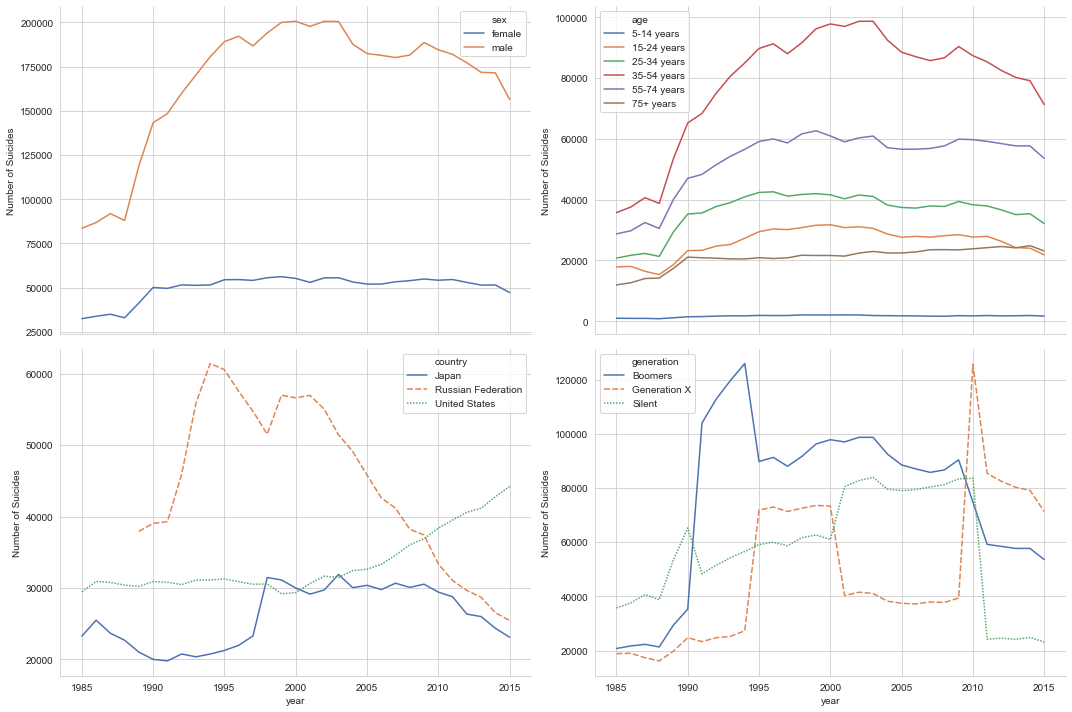

In [46]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, 
                       ncols=2, 
                       figsize=(15, 10), 
                       sharex=True)

generations = df.suicides_no.groupby(df.generation).sum().nlargest(3).index.tolist()

axes = np.copy(ax.flatten())
columns = ['sex', 'age', 'country', 'generation']
categories = [genders, ages, countries_a, generations]
for col, cat, axis in zip(columns, categories, axes):
    if col in ['age']:
        data = df.groupby([col, 'year']).sum().suicides_no.reindex(level=col, index=ages)
    else:
        data = df.groupby([col, 'year']).sum().suicides_no
    data = data[cat].reset_index()
    cond = col in ['generation', 'country']
    sns.lineplot(x='year', y='suicides_no', hue=col, style=col, data=data, sort=False, dashes=cond, ax=axis, palette='deep')
    axis.set_ylabel("Number of Suicides")
    #axis.legend(loc='upper left')
sns.despine()
plt.tight_layout()
plt.show()   

In [47]:
data = {'country': countries,
        'male'  :  male,
        'female' : female}

- As we have already seen, the rate of suicides for men is clearly higher than for women.
- Rates of suicide are higher between middle-aged men. 
- Suicide rates in Russia peaks in the first half of the 1990s, but it's declining ever since.
- The United States shows an almost linear rate between 1985 and 2000. However, from this point onward, it starts to increase year after year. 
- Among the generations, Boomers have shown the highest rates of suicide, peaking around 1994*.


<font size="2">*The generation variable doesn't furnish enough information. Furthermore, apparently there's no consensus on when a generation begins and ends. I decided to use it only for this particular plot.</font>

In [48]:
source = ColumnDataSource(data)

## Analysing correlation between variables

In [49]:
data = df.copy()
data = data.select_dtypes(include=['number'])

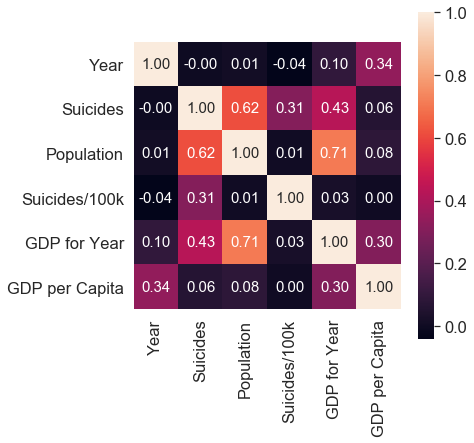

In [50]:
#Correlation Matrix
plt.figure(figsize=(6, 6))
xyticklabels = ['Year', 'Suicides', 'Population', 'Suicides/100k', 'GDP for Year', 'GDP per Capita']
cm = np.corrcoef(data[data.columns].values.T)
sns.set(font_scale=1.5)
sns.heatmap(cm,
            cbar=True,
            annot=True,
            square=True,
            fmt='.2f',
            annot_kws={'size': 15},
            yticklabels=xyticklabels,
            xticklabels=xyticklabels,
           )

plt.show()

As shown in the above correlation matrix, the number of suicides and the population of a certain country show a strong, positive correlation. Suicides and GDP for year also show some degree of correlation. Correlation measures linear relationships between variables, and we're going to explore some of these relationships further in the next cells.

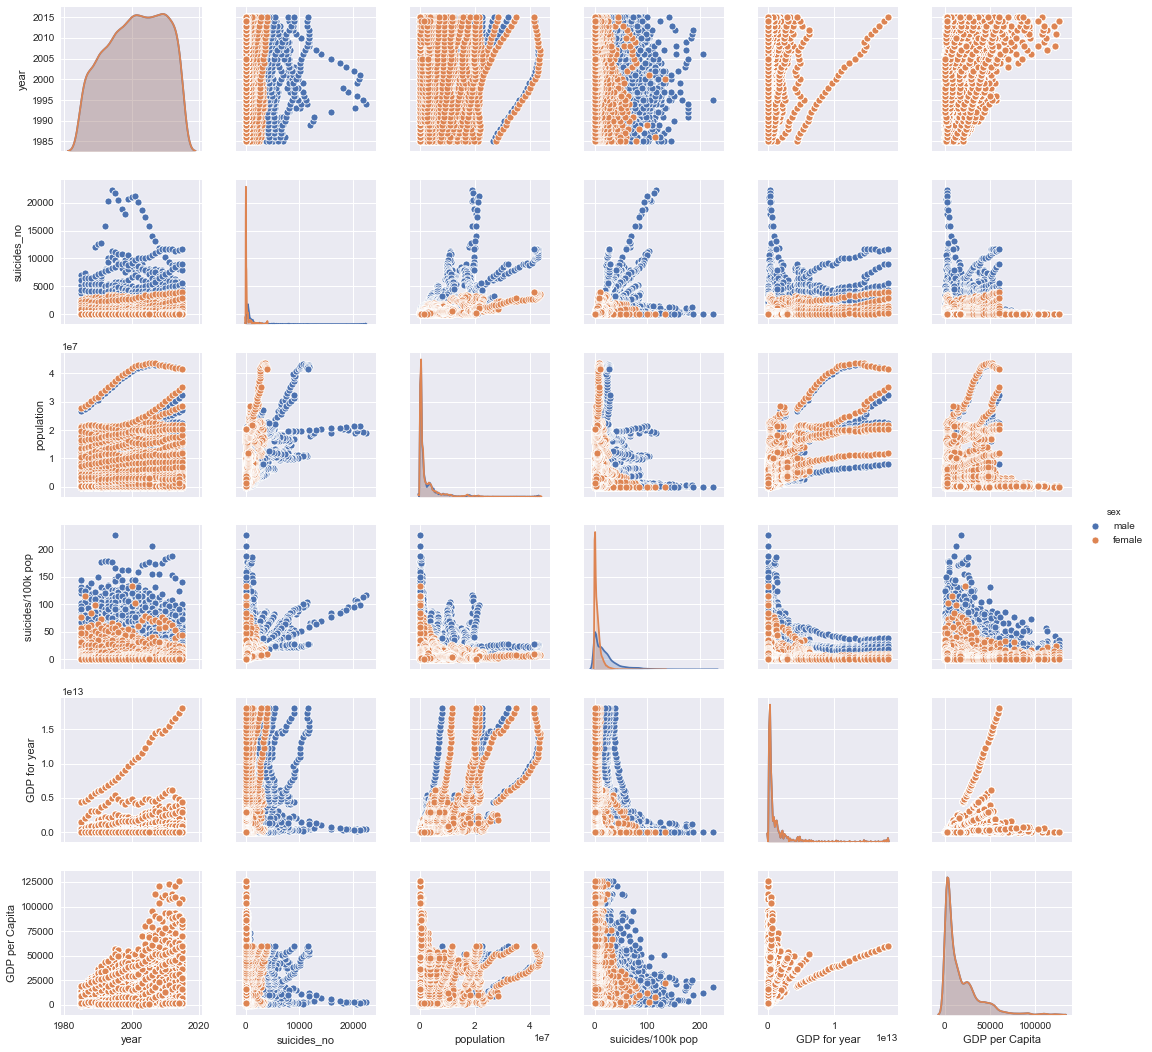

In [51]:
plt.style.use('seaborn')
sns.pairplot(data=df, hue='sex', palette='deep')
plt.show()